In [1]:
import json
import os
import cv2
import keras

import tensorflow as tf
import pandas as pd
import numpy as np

from PIL import Image
from glob import glob
from keras import backend as K

from keras.applications.densenet import DenseNet121, preprocess_input
#from keras.applications.mobilenetv2 import MobileNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import SGD, rmsprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.metrics import (categorical_accuracy, categorical_crossentropy,
                           top_k_categorical_accuracy)
from keras.layers import (Dense,Input, Conv2D, MaxPooling2D, 
                          Activation, Flatten, Dropout, Cropping2D, 
                          Lambda, GlobalAveragePooling2D, BatchNormalization, 
                          AveragePooling2D,Convolution2D)
            
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss
from sklearn.utils.class_weight import compute_class_weight

import imutils
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
tf.__version__, keras.__version__

('1.10.0', '2.2.4')

In [3]:
train_files = "C:/Users/mbura/Desktop/pycrewDataset/train/*"
train_path = "C:/Users/mbura/Desktop/pycrewDataset/train/"

In [4]:
labels = [paths.split("\\")[-1] for paths in glob(train_files + "*")]

### Get class weight

In [5]:
y = []

for label_path in glob(train_files):
    for pic in glob(label_path + "/*" ):
        label = pic.split("\\")[1]
        y.append(label)
    
#         img = cv2.imread(pic)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         X.append(img)
np.unique(y)

array(['a', 'd', 'nk', 's', 'sa', 'sd', 'w', 'wa', 'wd'], dtype='<U2')

In [6]:
class_weights = compute_class_weight('balanced', np.unique(y), y)
class_weights

array([ 3.74539972,  3.43844263,  1.21969864,  5.17634459, 20.65470085,
       19.5087333 ,  0.19274989,  0.93091976,  0.93706289])

## **Best Model: DenseNet121**

In [7]:
BS = 16
SIZE = 224
TEST_SIZE = 0.2

In [8]:
K.set_image_dim_ordering('tf')

def atan_layer(x):
    print(x, tf.mul(tf.atan(x), 2))
    return tf.mul(tf.atan(x), 2)

def atan_layer_shape(input_shape):
    return input_shape

def atan(x):
    return tf.atan(x)

def NVIDIA():
    
    """
            https://github.com/hdmetor/Nvidia-SelfDriving
    """
    
    inputs = Input(shape=(224, 224, 3))
    conv_1 = Convolution2D(24, 5, 5, activation='relu', name='conv_1', subsample=(2, 2))(inputs)
    conv_2 = Convolution2D(36, 5, 5, activation='relu', name='conv_2', subsample=(2, 2))(conv_1)
    conv_3 = Convolution2D(48, 5, 5, activation='relu', name='conv_3', subsample=(2, 2))(conv_2)
    conv_3 = Dropout(.5)(conv_3)

    conv_4 = Convolution2D(64, 3, 3, activation='relu', name='conv_4', subsample=(1, 1))(conv_3)
    conv_5 = Convolution2D(64, 3, 3, activation='relu', name='conv_5', subsample=(1, 1))(conv_4)

    flat = Flatten()(conv_5)

    dense_1 = Dense(1164)(flat)
    dense_1 = Dropout(.1)(flat)
    dense_2 = Dense(100, activation='relu')(dense_1)
    dense_2 = Dropout(.1)(flat)
    dense_3 = Dense(50, activation='relu')(dense_2)
    dense_3 = Dropout(.1)(flat)
    dense_4 = Dense(10, activation='relu')(dense_3)
    dense_4 = Dropout(.1)(flat)

    final = Dense(9, activation='softmax')(dense_4)
    
    model = Model(input=inputs, output=final)
    model.compile(optimizer=SGD(lr=1e-3, momentum=.9), loss="categorical_crossentropy", metrics=['accuracy'])
    
    return model

In [9]:
# model = NVIDIA()

In [10]:
log_dir = "./logs/densenet2/"

In [11]:
callbacks = [EarlyStopping(patience = 4, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 3, min_lr=0.000001, verbose=1, mode=min),
            ModelCheckpoint(log_dir + "ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5", monitor='val_loss', save_weights_only=True, save_best_only=True),
            TensorBoard(log_dir=log_dir)]

c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
# model.fit(X_train, y_train, batch_size=128, nb_epoch=100, verbose=1, callbacks=callbacks, validation_data=(X_test,y_test), shuffle=True, show_accuracy=True, class_weight=class_weights)


In [12]:
base_model = DenseNet121(include_top=False, weights='imagenet',
                         input_shape=(SIZE, SIZE, 3), classes=9)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(9, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


for layer in model.layers:  
    layer.trainable = True

model.compile(optimizer=Adam(lr=1e-3, decay=1e-9), loss="categorical_crossentropy", metrics=['accuracy'])


In [13]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  validation_split=TEST_SIZE)


train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(SIZE, SIZE),
        batch_size=BS,
        subset='training',
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size = (SIZE, SIZE),
        batch_size = BS,
        subset='validation',
        class_mode='categorical')


H = model.fit_generator(train_generator,
                        class_weight = class_weights,
                        shuffle=True,
                        workers = 8,
                        validation_data = validation_generator, 
                        validation_steps = validation_generator.samples  // BS,
                        callbacks = callbacks, 
                        steps_per_epoch = train_generator.samples // BS,
                        epochs = 30)

Found 106334 images belonging to 9 classes.
Found 26579 images belonging to 9 classes.
Epoch 1/30
6645/6645 [==============================] - 2653s 399ms/step - loss: 0.9327 - acc: 0.6554 - val_loss: 0.9114 - val_acc: 0.6727
Epoch 2/30
6645/6645 [==============================] - 2564s 386ms/step - loss: 0.8155 - acc: 0.6849 - val_loss: 0.8274 - val_acc: 0.6847
Epoch 3/30
6645/6645 [==============================] - 2566s 386ms/step - loss: 0.7800 - acc: 0.6955 - val_loss: 0.8119 - val_acc: 0.6847
Epoch 4/30
6645/6645 [==============================] - 2542s 383ms/step - loss: 0.7567 - acc: 0.7028 - val_loss: 0.9138 - val_acc: 0.6495
Epoch 5/30
6645/6645 [==============================] - 2542s 383ms/step - loss: 0.7400 - acc: 0.7076 - val_loss: 0.8065 - val_acc: 0.6907
Epoch 6/30
6645/6645 [==============================] - 2552s 384ms/step - loss: 0.7234 - acc: 0.7136 - val_loss: 0.7857 - val_acc: 0.7000
Epoch 7/30
6645/6645 [==============================] - 2542s 383ms/step - loss

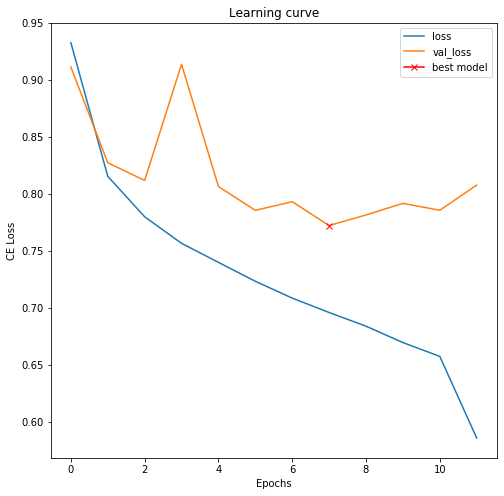

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(H.history["loss"], label="loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
plt.legend()

In [91]:
# with open('densenetv2.json','r') as f:
#     model_json = json.load(f)

# model = model_from_json(model_json)
# model.load_weights(r"./logs/nvidia/ep001-loss1.410-val_loss1.461.h5")

In [34]:
model.load_weights("logs/densenet2/ep008-loss0.696-val_loss0.772.h5")

In [35]:
filenames = validation_generator.filenames
nb_samples = len(filenames)
nb_samples

26579

In [36]:
inv_map = {v: k for k, v in validation_generator.class_indices.items()} 
inv_map

{0: 'a', 1: 'd', 2: 'nk', 3: 's', 4: 'sa', 5: 'sd', 6: 'w', 7: 'wa', 8: 'wd'}

In [37]:
test_generator = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    validation_split=TEST_SIZE).flow_from_directory(train_path,
                                                                                    shuffle=False,
                                                                                    target_size = (SIZE, SIZE),
                                                                                    batch_size = BS,
                                                                                    subset='validation',
                                                                                    class_mode='categorical')

Found 26579 images belonging to 9 classes.


In [38]:
predict = model.predict_generator(test_generator, steps = nb_samples//BS, verbose = 1)

1661/1661 [==============================] - 171s 103ms/step


In [39]:
y_pred = np.rint(predict)
y_true = validation_generator.classes[:len(y_pred)]

In [40]:
y_pred_labels = [inv_map[np.argmax(pred_, axis = -1)] for pred_ in y_pred]
y_true_labels = [inv_map[pred_] for pred_ in y_true]

In [41]:
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           a       0.19      0.70      0.30       788
           d       0.65      0.26      0.37       859
          nk       0.58      0.62      0.60      2421
           s       0.54      0.20      0.30       570
          sa       0.54      0.05      0.09       143
          sd       0.46      0.04      0.07       151
           w       0.78      0.87      0.82     15323
          wa       0.63      0.41      0.49      3172
          wd       0.68      0.33      0.44      3149

    accuracy                           0.68     26576
   macro avg       0.56      0.39      0.39     26576
weighted avg       0.70      0.68      0.67     26576



In [76]:
# ## Save weights & model structure:

# model.save_weights('densenet_yenidata.h5')

In [15]:
model_json = model.to_json()
with open("densenetv2.json", "w") as json_file:
    json.dump(model_json, json_file)

In [89]:
# from keras.models import load_model
from keras.models import model_from_json
# import json

# ## Reload weights & model structure:

# with open('model_in_json.json','r') as f:
#     model_json = json.load(f)

# model = model_from_json(model_json)
# model.load_weights('model.h5')


In [93]:
"""" trainv1 : MobileNetV2 - 16 Epoch 
                precision    recall  f1-score   support
        
           a       0.24      0.71      0.36       271
           d       0.42      0.55      0.47       290
          nk       0.53      0.41      0.46       813
           s       0.56      0.17      0.26       193
          sa       0.50      0.33      0.40        52
          sd       0.22      0.25      0.23        53
           w       0.79      0.65      0.71      4940
          wa       0.41      0.63      0.49      1038
          wd       0.46      0.48      0.47      1022

    accuracy                           0.59      8672
   macro avg       0.46      0.46      0.43      8672
weighted avg       0.64      0.59      0.60      8672"""


""""  DenseNet121: 3 Epoch

                precision    recall  f1-score   support

           a       0.20      0.86      0.33       543
           d       0.68      0.29      0.41       580
          nk       0.62      0.33      0.43      1627
           s       0.00      0.00      0.00       387
          sa       0.00      0.00      0.00       104
          sd       0.00      0.00      0.00       106
           w       0.94      0.81      0.87      5325
          wa       0.00      0.00      0.00         0
          wd       0.00      0.00      0.00         0

    accuracy                           0.63      8672
   macro avg       0.27      0.25      0.23      8672
weighted avg       0.75      0.63      0.66      8672""""

""" DenseNet121: 12 Epoch - Last epoch weights

precision    recall  f1-score   support

           a       0.27      0.60      0.37       788
           d       0.59      0.39      0.47       859
          nk       0.59      0.55      0.57      2421
           s       0.45      0.46      0.46       570
          sa       0.54      0.24      0.34       143
          sd       0.55      0.17      0.26       151
           w       0.78      0.87      0.82     15323
          wa       0.61      0.43      0.50      3172
          wd       0.63      0.40      0.49      3149

    accuracy                           0.69     26576
   macro avg       0.56      0.46      0.48     26576
weighted avg       0.70      0.69      0.68     26576"""

"""DenseNet121: 12 Epoch - Best
              precision    recall  f1-score   support

           a       0.19      0.70      0.30       788
           d       0.65      0.26      0.37       859
          nk       0.58      0.62      0.60      2421
           s       0.54      0.20      0.30       570
          sa       0.54      0.05      0.09       143
          sd       0.46      0.04      0.07       151
           w       0.78      0.87      0.82     15323
          wa       0.63      0.41      0.49      3172
          wd       0.68      0.33      0.44      3149

    accuracy                           0.68     26576
   macro avg       0.56      0.39      0.39     26576
weighted avg       0.70      0.68      0.67     26576"""

'" trainv1      \n                precision    recall  f1-score   support\n        \n           a       0.24      0.71      0.36       271\n           d       0.42      0.55      0.47       290\n          nk       0.53      0.41      0.46       813\n           s       0.56      0.17      0.26       193\n          sa       0.50      0.33      0.40        52\n          sd       0.22      0.25      0.23        53\n           w       0.79      0.65      0.71      4940\n          wa       0.41      0.63      0.49      1038\n          wd       0.46      0.48      0.47      1022\n\n    accuracy                           0.59      8672\n   macro avg       0.46      0.46      0.43      8672\nweighted avg       0.64      0.59      0.60      8672'